### Features to use

Main tactical features to use:
- Wide/central (off/def)
- Directness
- Pass length
- Tempo
- Restförsvar ?
- Fasta situationer ?
- Press, triggers (defensiva aktioner i offensiv planhalva) (tid för bollvinst)
- Höjd på backlinje
- Antal progressiva passningar
- Bollhastighet
- Final third entries

In [23]:
#Pitch zone splitup
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from matplotlib.patches import Rectangle

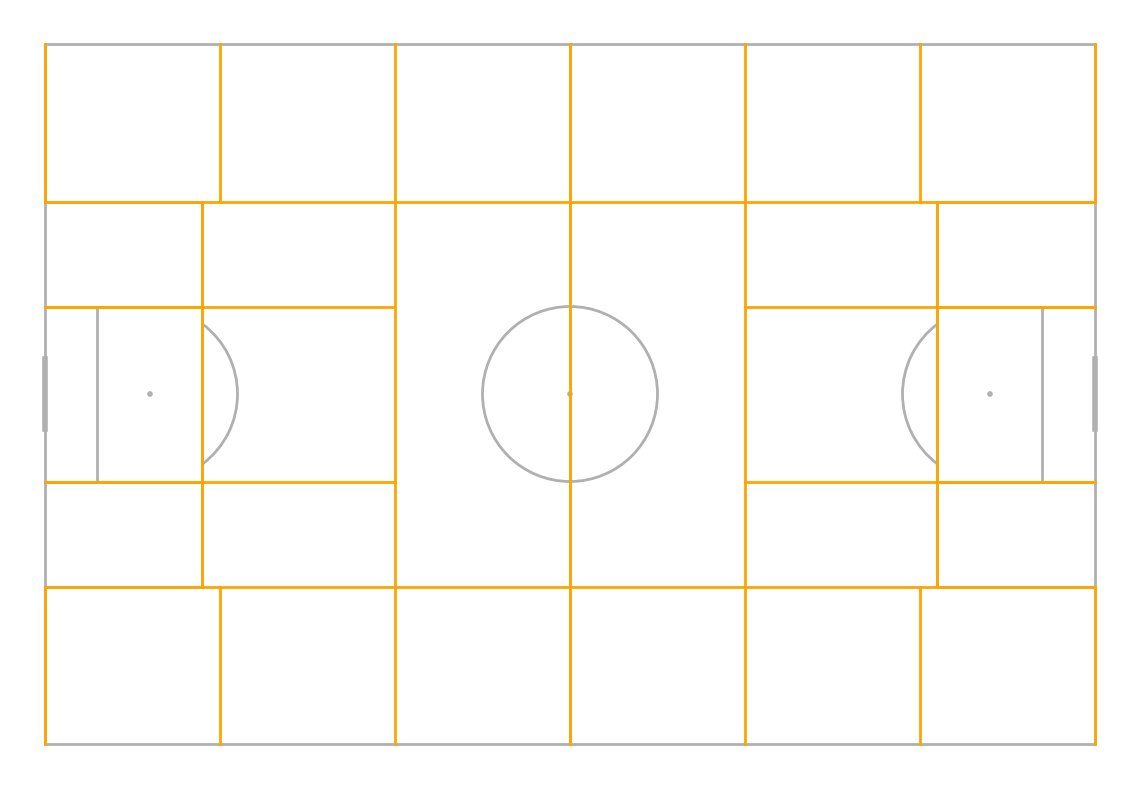

In [42]:



PITCH_L, PITCH_W = 120, 80
Y_TOP = 18
Y_MID1 = 30
Y_MID2 = 50
Y_BOT = 62
y_bands = [0, Y_TOP, Y_MID1, Y_MID2, Y_BOT, 80]

# Wide channels are split into N columns (small boxes)
N_WIDE_COLS = 6
x_bins_wide = np.linspace(0, 120, N_WIDE_COLS + 1)  # 0..120 inclusive

# Penalty area (StatsBomb)
PA_L_X0, PA_L_X1 = 0, 18
PA_R_X0, PA_R_X1 = 102, 120
PA_Y0, PA_Y1 = 18, 62

# Your special penalty split using 6-yard box y-bounds
PA_SPLIT_Y1 = 30
PA_SPLIT_Y2 = 50


pitch = Pitch(pitch_type="statsbomb")
fig, ax = pitch.draw(figsize=(12, 8))

# Horizontal band lines (full width)
for y in [Y_TOP, Y_MID1, Y_MID2, Y_BOT]:
    ax.plot([0, 40], [y, y], color="orange", lw=2)
    ax.plot([80, 120], [y, y], color="orange", lw=2)

# Vertical lines ONLY in wide bands (top and bottom), to form the small boxes
for x in x_bins_wide:
    # top band
    ax.plot([x, x], [0, Y_TOP], color="orange", lw=2)
    # bottom band
    ax.plot([x, x], [Y_BOT, 80], color="orange", lw=2)

# Vertical midfield line across central corridor (to make big rectangles left/right)
ax.plot([60, 60], [Y_TOP, Y_BOT], color="orange", lw=2)

# Penalty-area 3-band split lines (only across the penalty box width)
for y in [PA_SPLIT_Y1, PA_SPLIT_Y2]:
    # left PA
    ax.plot([PA_L_X0, PA_L_X1], [y, y], color="orange", lw=2)
    # right PA
    ax.plot([PA_R_X0, PA_R_X1], [y, y], color="orange", lw=2)

ax.plot([PA_L_X1,PA_L_X1],[PA_Y0,PA_Y1], color="orange", lw=2)
ax.plot([PA_R_X0,PA_R_X0],[PA_Y0,PA_Y1], color="orange", lw=2)

#Dead zone:
CENTER_W = 40   # how wide (x-direction)
CENTER_H = 44   # how tall (y-direction)

cx, cy = 60, 40
x0 = cx - CENTER_W / 2
y0 = cy - CENTER_H / 2
MID_X0 = cx - CENTER_W/2
MID_X1 = cx + CENTER_W/2
MID_Y0 = cy - CENTER_H/2
MID_Y1 = cy + CENTER_H/2

# Center box
ax.add_patch(Rectangle((x0, y0), CENTER_W, CENTER_H,
                       fill=False, edgecolor="orange", lw=2))



def get_zone(x: float, y: float) -> str:
    # penalty areas override everything
    in_left_pa  = (PA_L_X0 <= x <= PA_L_X1) and (PA_Y0 <= y <= PA_Y1)
    in_right_pa = (PA_R_X0 <= x <= PA_R_X1) and (PA_Y0 <= y <= PA_Y1)

    if in_left_pa:
        if y < PA_SPLIT_Y1: return "PenBox_Def_Left"
        elif y <= PA_SPLIT_Y2: return "PenBox_Def_Central"
        else: return "PenBox_Def_Right"

    if in_right_pa:
        if y < PA_SPLIT_Y1: return "PenBox_Att_Left"
        elif y <= PA_SPLIT_Y2: return "PenBox_Att_Central"
        else: return "PenBox_Att_Right"

    if (MID_X0 <= x <= MID_X1) and (MID_Y0 <= y <= MID_Y1):
        return "Center_Dead_Def" if x < 60 else "Center_Dead_Att"


    # wide channels
    if y < Y_TOP:
        col = np.digitize([x], x_bins_wide)[0] - 1
        col = int(np.clip(col, 0, N_WIDE_COLS - 1))
        return f"Wing_Left_Zone{col}"

    if y > Y_BOT:
        col = np.digitize([x], x_bins_wide)[0] - 1
        col = int(np.clip(col, 0, N_WIDE_COLS - 1))
        return f"Wing_Right_Zone{col}"

    # central corridor (non-dead)
    if y < 30:
        pocket_y = "Left"
    elif y <= 50:
        pocket_y = "Central"
    else:
        pocket_y = "Right"


    return f"{'Def' if x < 60 else 'Att'}_Pocket_{pocket_y}"



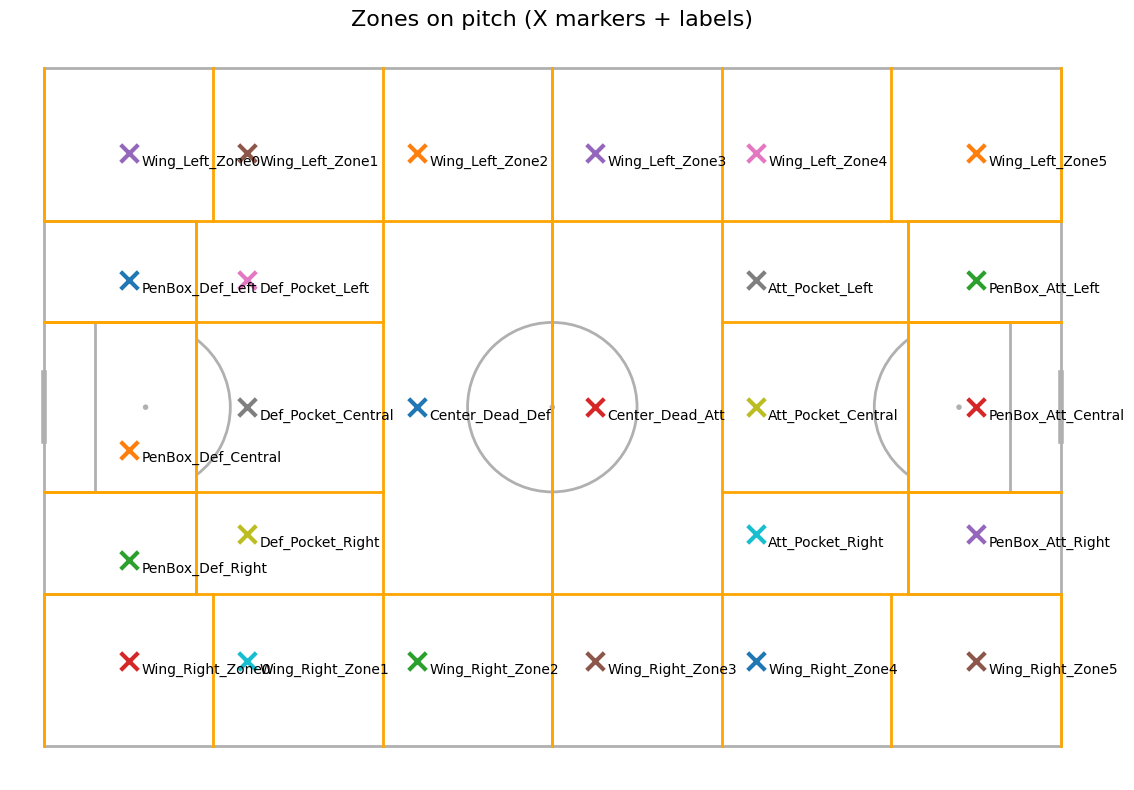

In [44]:


def draw_grid(ax):
    # Horizontal band lines only on [0,40] and [80,120] (as you did)
    for y in [Y_TOP, Y_MID1, Y_MID2, Y_BOT]:
        ax.plot([0, 40], [y, y], color="orange", lw=2)
        ax.plot([80, 120], [y, y], color="orange", lw=2)

    # Wide band vertical lines
    for x in x_bins_wide:
        ax.plot([x, x], [0, Y_TOP], color="orange", lw=2)
        ax.plot([x, x], [Y_BOT, 80], color="orange", lw=2)

    # Midfield line inside central corridor
    ax.plot([60, 60], [Y_TOP, Y_BOT], color="orange", lw=2)

    # Penalty split lines
    for y in [PA_SPLIT_Y1, PA_SPLIT_Y2]:
        ax.plot([PA_L_X0, PA_L_X1], [y, y], color="orange", lw=2)
        ax.plot([PA_R_X0, PA_R_X1], [y, y], color="orange", lw=2)

    ax.plot([PA_L_X1, PA_L_X1], [PA_Y0, PA_Y1], color="orange", lw=2)
    ax.plot([PA_R_X0, PA_R_X0], [PA_Y0, PA_Y1], color="orange", lw=2)

    # Dead zone rectangle
    ax.add_patch(Rectangle((MID_X0, MID_Y0), CENTER_W, CENTER_H,
                           fill=False, edgecolor="orange", lw=2))


def plot_points_pitch(points):
    pitch = Pitch(pitch_type="statsbomb")
    fig, ax = pitch.draw(figsize=(12, 8))
    draw_grid(ax)

    for (x, y) in points:
        z = get_zone(x, y)
        ax.scatter(x, y, marker="x", s=160, linewidths=3)  # big X
        ax.text(x + 1.5, y + 1.5, z, fontsize=10)

    ax.set_title("Zones on pitch (X markers + labels)", fontsize=16)
    plt.show()


pts = [
    (10, 25),
    (10, 45),
    (10, 58),
        (10, 70),
    (10, 10),
    (24, 10),
        (24, 25),
            (24, 40),
                (24, 55),
                    (24, 70),
                (44, 40),
                (44, 10),
                    (44, 70),
    (65, 40),
        (65, 10),
            (65, 70),



    (84, 10),
        (84, 25),
            (84, 40),
                (84, 55),
                    (84, 70),

        (110, 10),
        (110, 25),
            (110, 40),
                (110, 55),
                    (110, 70),
]

plot_points_pitch(pts)